In [5]:
import ase
from ase import io
from pathlib import Path
from ase import visualize
files = list(Path(".").glob("benchmark_symmetry*xyz"))
files

[PosixPath('benchmark_symmetry_3.sdf.xyz'),
 PosixPath('benchmark_symmetry_35.sdf.xyz'),
 PosixPath('benchmark_symmetry_18.sdf.xyz'),
 PosixPath('benchmark_symmetry_2.sdf.xyz'),
 PosixPath('benchmark_symmetry_28.sdf.xyz'),
 PosixPath('benchmark_symmetry_31.sdf.xyz'),
 PosixPath('benchmark_symmetry_25.sdf.xyz'),
 PosixPath('benchmark_symmetry_23.sdf.xyz'),
 PosixPath('benchmark_symmetry_5.sdf.xyz'),
 PosixPath('benchmark_symmetry_4.sdf.xyz'),
 PosixPath('benchmark_symmetry_27.sdf.xyz'),
 PosixPath('benchmark_symmetry_13.sdf.xyz'),
 PosixPath('benchmark_symmetry_37.sdf.xyz'),
 PosixPath('benchmark_symmetry_6.sdf.xyz'),
 PosixPath('benchmark_symmetry_32.sdf.xyz'),
 PosixPath('benchmark_symmetry_24.sdf.xyz'),
 PosixPath('benchmark_symmetry_34.sdf.xyz'),
 PosixPath('benchmark_symmetry_22.sdf.xyz'),
 PosixPath('benchmark_symmetry_29.sdf.xyz'),
 PosixPath('benchmark_symmetry_15.sdf.xyz'),
 PosixPath('benchmark_symmetry_16.sdf.xyz'),
 PosixPath('benchmark_symmetry_19.sdf.xyz'),
 PosixPath('ben

In [6]:
index=5
fn = files[index]

atoms = ase.io.read(fn)
ase.io.write("test.xyz", atoms)

ase.visualize.view(atoms, viewer="x3d")

In [7]:
# pyscf_example_full.py

! uv pip install --force-reinstall pyscf[all]

from pyscf import gto, dft, grad, hessian
from pyscf.geomopt import berny_solver
from pyscf.tools import cubegen
import numpy as np

# ---------------------------
# 1) Molecule & method
# ---------------------------
mol = gto.Mole()
mol.atom = """test.xyz"""
mol.basis = "def2-SVP"
mol.charge = 0
mol.spin = 0
mol.build()

mf = dft.RKS(mol)
mf.xc = "PBE0"
mf.conv_tol = 1e-9
mf.verbose = 4

# ---------------------------
# 2) Single-point energy
# ---------------------------
e_tot = mf.kernel()
print(f"\nTotal electronic energy (B3LYP/def2-SVP): {e_tot:.10f} Ha")

# ---------------------------
# 3) Forces (nuclear gradients)
# ---------------------------
g = grad.RKS(mf).kernel()   # shape (Natoms, 3), units: Hartree/Bohr
print("\nForces (Hartree/Bohr):\n", g)

# ---------------------------
# 4) Multipoles: dipole (built-in) + traceless quadrupole (manual)
# ---------------------------
# Dipole (includes electronic + nuclear, by default). In Debye.
dip = mf.dip_moment(unit='Debye')
print("\nDipole moment (Debye) [Dx, Dy, Dz]:", np.array(dip))

# # Traceless quadrupole Q_ij = sum_A Z_A*(3 R_Ai R_Aj - R_A^2 δ_ij) - ∫ρ(r)*(3 r_i r_j - r^2 δ_ij) d^3r
# # We'll form electronic part from AO integrals of r_i r_j and the 1-RDM; add nuclei analytically.
# # Output in atomic units of e·Bohr^2.
# ao_rr = mol.intor('int1e_rr')            # shape (3,3, nao, nao): <μ | r_i r_j | ν>
# dm1 = mf.make_rdm1()                     # AO 1-RDM
# # Electronic second moments: M_ij^el = Tr[dm1 * <r_i r_j>]
# M_el = np.einsum('ijxy,xy->ij', ao_rr, dm1, optimize=True)

# # Build traceless electronic quadrupole part: Q_el_ij = -(3 M_ij^el - Tr(M_el) δ_ij)
# tr_Mel = np.trace(M_el)
# Q_el = -(3.0 * M_el - tr_Mel * np.eye(3))

# # Nuclear contribution
# coords = mol.atom_coords()               # Bohr
# charges = mol.atom_charges().astype(float)
# Q_nuc = np.zeros((3,3))
# for A, ZA in enumerate(charges):
#     RA = coords[A]
#     r2 = np.dot(RA, RA)
#     Q_nuc += ZA * (3.0 * np.outer(RA, RA) - r2 * np.eye(3))

# Q_tot = Q_el + Q_nuc

# # Report traceless quadrupole (symmetric, 6 unique comps)
# def sym6(M):
#     return np.array([M[0,0], M[1,1], M[2,2], M[0,1], M[0,2], M[1,2]])
# print("\nTraceless quadrupole tensor (a.u., e·Bohr^2) [Qxx,Qyy,Qzz,Qxy,Qxz,Qyz]:")
# print(sym6(0.5*(Q_tot + Q_tot.T)))


# ---------------------------
# 6) Geometry optimization (Berny, internal to PySCF)
# ---------------------------
print("\n=== Geometry Optimization ===")
mol_opt = berny_solver.optimize(mf)  # returns a new Mole with optimized geometry
print("\nOptimized geometry (Bohr):\n", mol_opt.atom_coords())

# Rebuild a method on optimized geometry for frequencies
mf_opt = dft.RKS(mol_opt)
mf_opt.xc = "PBE0"
mf_opt.conv_tol = 1e-10
mf_opt.kernel()
print(f"\nOptimized energy: {mf_opt.e_tot:.10f} Ha")

# ---------------------------
# 7) Harmonic frequency analysis (Hessian)
# ---------------------------
# This returns the Cartesian Hessian (mass-unweighted) in a.u.; we'll use PySCF's built-in analysis helper.
# hess = hessian.RKS(mf_opt).kernel()

# # Convert to normal modes / frequencies (cm^-1) with internal helper:
# from pyscf.hessian import thermo
# freq_cm, modes = thermo.harmonic_analysis(mol_opt, hess)  # frequencies (cm^-1), normal mode vectors
# print("\nHarmonic frequencies (cm^-1):")
# print(np.round(freq_cm, 2))

# # Optional: basic thermochemistry (rigid-rotor, harmonic oscillator)
# T = 298.15  # K
# P = 101325  # Pa
# thermo_props = thermo.thermo(mol_opt, hess, T=T, P=P)  # returns a dict with ZPE, H, G, Cp, S, etc.
# print("\nThermochemistry @ 298.15 K, 1 atm (kcal/mol unless noted):")
# for k, v in thermo_props.items():
#     print(f"{k}: {v}")

Resolved 32 packages in 1.34s                                        
Prepared 32 packages in 367ms                                            
Installed 32 packages in 283ms.11                           
 + argcomplete==3.6.2
 + attrs==25.3.0
 + basis-set-exchange==0.11
 + cppe==0.3.1
 + geometric==1.1
 + h5py==3.14.0
 + jsonschema==4.25.1
 + jsonschema-specifications==2025.4.1
 + networkx==3.4.2
 + numpy==1.26.4
 + pandas==2.3.2
 + pyberny==0.6.3
 + pybind11==3.0.1
 + pyqmc==0.6.0
 + pyscf==2.7.0
 + pyscf-dispersion==1.3.0
 + pyscf-doci==0.1.0
 + pyscf-forge==1.0.3
 + pyscf-properties==0.1.0
 + pyscf-qsdopt==0.1.0
 + pyscf-semiempirical==0.1.1
 + python-dateutil==2.9.0.post0
 + pytz==2025.2
 + referencing==0.36.2
 + regex==2025.9.1
 + rpds-py==0.27.1
 + scipy==1.15.3
 + setuptools==80.9.0
 + six==1.17.0
 + typing-extensions==4.15.0
 + tzdata==2025.2
 + unidecode==1.4.0


******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS
initial guess = minao


/home/ericb/.cache/uv/builds-v0/.tmpAMqrVb/lib/python3.10/site-packages/berny/species_data.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpdck5ksjj
max_memory 4000 MB (current use 148 MB)
XC library pyscf.dft.libxc version 6.1.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
XC functionals = PBE0
    C. Adamo and V. Barone.,  J. Chem. Phys. 110, 6158 (1999)
    M. Ernzerhof and G. E. Scuseria.,  J. Chem. Phys. 110, 5029 (1999)
small_rho_cutoff = 1e-07
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
init E= -343.455759314878
  HOMO = -0.352828009796743  LUMO = -0.0832793208528144
cycle= 1 E= -342.714180611451  delta_E= 0.742  |g|= 1.11  |ddm|= 3.45
  HOMO = -0.119906592701849  LUMO = 0.0324200441299223
cycle= 2 E= -342.152544539629  delta_E= 0.562  |g|= 2.02  |ddm|= 2.72
  HOMO = -0.26

In [38]:
mol = mf_opt.mol
# ---------------------------
# 5) CUBE files: electron density & ESP
# ---------------------------
dm1 = mf_opt.make_rdm1()
# dm2 = mf_opt.make_rdm2()                     # AO 1-RDM
# Electron density cube (on a grid auto-chosen from molecule extents)
cubegen.density(mf_opt.mol, "density.cube", dm1)
# Molecular electrostatic potential (ESP) cube from the SCF solution:
# (Uses nuclei + electronic density.)
cubegen.mep(mf_opt.mol, "esp.cube", dm1)   # if your PySCF is older, this may be cubegen.potential(..., mf=mf)

print("\nWrote: density.cube and esp.cube")



Wrote: density.cube and esp.cube


In [39]:
# cubegen.potential(mf_opt.mol, "esp2.cube", mf=mf_opt)   # if your PySCF is older, this may be cubegen.potential(..., mf=mf)


In [40]:
mf_opt.mol.atom_charges()

array([9, 6, 9, 9, 1], dtype=int32)

In [57]:
from ase import visualize

In [58]:
cube_esp = cubegen.Cube(mf_opt.mol).read("esp.cube")

In [77]:
opt_atoms = ase.Atoms(mf_opt.mol.atom_charges(),  mf_opt.mol.atom_coords() * ase.units.Bohr)
ase.visualize.view(opt_atoms, viewer="x3d")

In [42]:
cube_dens = cubegen.Cube(mf_opt.mol).read("density.cube")

In [43]:
cube_esp.shape

(80, 80, 80)

In [1]:
# import patchworklib as pw
# import numpy as np
# import matplotlib.pyplot as plt

# def get_slice(vol, axis, idx):
#     if axis == 0:   # axial
#         sl = vol[idx, :, :]
#     elif axis == 1: # coronal
#         sl = vol[:, idx, :]
#     else:           # sagittal
#         sl = vol[:, :, idx]
#     return np.asarray(sl)

# def plot_offset_slices(
#     vol,
#     axis=0,
#     slices=None,          # e.g. [8, 12, 16, 20]
#     offset=(12, 12),      # (dx, dy) pixel shift per layer
#     alpha_range=(0.25, 0.85),
#     cmap="gray",
#     outline=True,
#     outline_color="k",
#     outline_lw=0.6,
#     vmin=None,
#     vmax=None,
#     title=None,
#     hide_axes=True,
# ):
#     """
#     Draws multiple 2D slices as semi-transparent layers, each offset by (dx, dy).
#     """
#     # Choose default slices (evenly spaced) if not provided
#     nZ, nY, nX = vol.shape
#     dim_len = [nZ, nY, nX][axis]
#     if slices is None:
#         count = 6
#         slices = np.linspace(dim_len*0.2, dim_len*0.8, count, dtype=int).tolist()

#     # Normalize color scale across the whole volume unless vmin/vmax provided
#     if vmin is None or vmax is None:
#         vmin = np.percentile(vol, 1) if vmin is None else vmin
#         vmax = np.percentile(vol, 99) if vmax is None else vmax

#     # Base slice to get width/height in displayed coordinates
#     ref = get_slice(vol, axis, slices[0])
#     H, W = ref.shape

#     # Prepare figure
#     # fig, ax = plt.subplots(figsize=(6, 6))
#     # ax.set_aspect("equal")
#     ax = pw.Brick()

#     # Alpha ramp (back-most = lower alpha)
#     alphas = np.linspace(alpha_range[0], alpha_range[1], len(slices))

#     # Draw from back to front
#     for k, (idx, a) in enumerate(zip(slices, alphas)):
#         sl = get_slice(vol, axis, idx)

#         # Compute pixel-space offset
#         dx = k * offset[0] 
#         dy = k * offset[1]

#         # Place slice using extent shifted by (dx, dy)
#         extent = [dx, dx + W, dy, dy + H]
#         im = ax.imshow(sl, cmap=cmap, origin="lower",
#                        vmin=vmin, vmax=vmax, extent=extent, alpha=a, interpolation="nearest")

#         # Optional outline to emphasize the layer boundary
#         if outline:
#             ax.plot([dx, dx+W, dx+W, dx, dx],
#                     [dy, dy,   dy+H, dy+H, dy],
#                     outline_color, lw=outline_lw, alpha=min(1.0, a+0.15))

#         # # Label slice index (small, unobtrusive)
#         # ax.text(dx + 4, dy + H - 10, f"{['Z','Y','X'][axis]}={idx}",
#         #         fontsize=8, color=outline_color, alpha=0.75)

#     # Colorbar (shared scale)
#     cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#     # cbar.set_label("ESP")

#     # Framing
#     if hide_axes:
#         ax.set_xticks([]); ax.set_yticks([])
#         for spine in ax.spines.values():
#             spine.set_visible(False)

#     # Title
#     if title is None:
#         title = f"Offset layers — axis {['Z (axial)','Y (coronal)','X (sagittal)'][axis]}"
#     ax.set_title(title)

#     return ax

# # -------------------
# # Example usage:
# # vol = np.random.rand(40, 128, 128)  # (Z, Y, X)  <-- replace with your data
# esp1 = plot_offset_slices(cube_esp,
#                    axis=0,
#                    slices=list(np.arange(1,cube_esp.shape[0],cube_esp.shape[0]//3)),
#                    offset=(10, 8),
#                    cmap="coolwarm",
#                    title="",
#                    vmin=-0.0005,
#                    vmax=0.0005,
#                    outline=True)


# esp2 = plot_offset_slices(cube_esp,
#                    axis=0,
#                    slices=list(np.arange(1,cube_esp.shape[0],cube_esp.shape[0]//3)),
#                    offset=(10, 8),
#                    cmap="coolwarm",
#                    title="",
#                    vmin=-0.01,
#                    vmax=0.01,
#                    outline=True)
# dens1 = plot_offset_slices(cube_dens,
#                    axis=0,
#                     slices=list(np.arange(1,cube_esp.shape[0],cube_esp.shape[0]//3)),
#                            offset=(10, 8),
#                    cmap="jet",
#                    title="",
#                    # vmin=0,
#                    # vmax=0.1,
#                    outline=True)

# esp1 | esp2 | dens1

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def get_slice(vol, axis, idx):
    if axis == 0:   # axial
        return np.asarray(vol[idx, :, :])
    elif axis == 1: # coronal
        return np.asarray(vol[:, idx, :])
    else:           # sagittal
        return np.asarray(vol[:, :, idx])

def plot_offset_slices(
    vol,
    axis=0,
    slices=None,                # e.g. [8,12,16,20]
    offset=(12, 12),            # pixel shift per layer (dx, dy)
    alpha_range=(0.25, 0.85),   # back..front opacity
    cmap="gray",
    outline=True,
    outline_color="k",
    outline_lw=0.6,
    vmin=None,
    vmax=None,
    title=None,
    hide_axes=True,
    # --- masking controls ---
    mask_volume=None,           # 3D bool array same shape as vol; True = transparent
    mask_slices=None,           # dict {slice_idx: 2D bool mask}
    mask_fn=None,               # function(slice2d, idx) -> 2D bool mask
    transparent_outside="both", # "both", "below", "above", or None
):
    """
    Draws multiple 2D slices as semi-transparent layers, each offset by (dx, dy).
    Pixels masked by any of: mask_slices/mask_volume/mask_fn OR lying outside [vmin, vmax]
    (according to `transparent_outside`) are fully transparent.
    """

    nZ, nY, nX = vol.shape
    dim_len = [nZ, nY, nX][axis]

    if slices is None:
        count = 6
        slices = np.linspace(dim_len*0.2, dim_len*0.8, count, dtype=int).tolist()

    # Global vmin/vmax unless provided
    if vmin is None or vmax is None:
        vmin = np.percentile(vol, 1) if vmin is None else vmin
        vmax = np.percentile(vol, 99) if vmax is None else vmax

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect("equal")

    alphas = np.linspace(alpha_range[0], alpha_range[1], len(slices))

    def get_mask_for(idx, sl):
        # 1) explicit per-slice mask dict
        if mask_slices is not None and idx in mask_slices:
            m = np.asarray(mask_slices[idx]).astype(bool)
            if m.shape != sl.shape:
                raise ValueError(f"mask_slices[{idx}].shape {m.shape} != slice {sl.shape}")
            return m
        # 2) 3D mask volume
        if mask_volume is not None:
            mv = np.asarray(mask_volume)
            if mv.shape != vol.shape:
                raise ValueError(f"mask_volume.shape {mv.shape} != vol.shape {vol.shape}")
            m = get_slice(mv, axis, idx).astype(bool)
            if m.shape != sl.shape:
                raise ValueError("Derived mask slice shape mismatch.")
            return m
        # 3) function
        if mask_fn is not None:
            m = np.asarray(mask_fn(sl, idx)).astype(bool)
            if m.shape != sl.shape:
                raise ValueError("mask_fn returned shape != slice shape.")
            return m
        # 4) no mask
        return np.zeros_like(sl, dtype=bool)

    last_im = None
    # Draw from back to front
    for k, (idx, a) in enumerate(zip(slices, alphas)):
        sl = get_slice(vol, axis, idx)
        H, W = sl.shape

        # offsets
        dx = k * offset[0]
        dy = k * offset[1]
        extent = [dx, dx + W, dy, dy + H]

        # build outside-of-scale mask
        if transparent_outside in (True, "both"):
            m_out = (sl < vmin) | (sl > vmax)
        elif transparent_outside == "below":
            m_out = (sl < vmin)
        elif transparent_outside == "above":
            m_out = (sl > vmax)
        else:
            m_out = np.zeros_like(sl, dtype=bool)

        # combine with user masks (True = transparent)
        m_user = get_mask_for(idx, sl)
        m_total = m_out | m_user

        # per-pixel alpha: fully transparent where m_total True
        alpha_map = a * (~m_total).astype(float)

        # draw
        last_im = ax.imshow(
            sl, cmap=cmap, origin="lower",
            vmin=vmin, vmax=vmax,
            extent=extent, interpolation="nearest",
            alpha=alpha_map
        )

        # outline only if anything is visible from this slice
        if outline and (~m_total).any():
            ax.plot([dx, dx+W, dx+W, dx, dx],
                    [dy, dy,   dy+H, dy+H, dy],
                    outline_color, lw=outline_lw, alpha=min(1.0, a+0.15))

        # ax.text(dx + 4, dy + H - 10, f"{['Z','Y','X'][axis]}={idx}",
        #         fontsize=8, color=outline_color, alpha=0.75)

    cbar = fig.colorbar(last_im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Intensity")

    if hide_axes:
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)

    if title is None:
        title = f"Offset layers — axis {['Z (axial)','Y (coronal)','X (sagittal)'][axis]}"
    ax.set_title(title)
    return ax
    # plt.tight_layout()
    # plt.show()


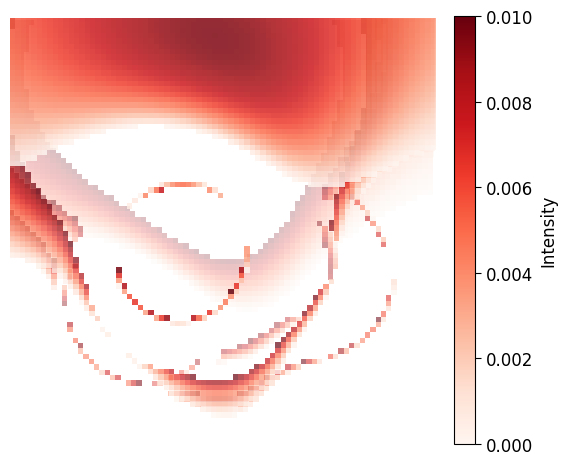

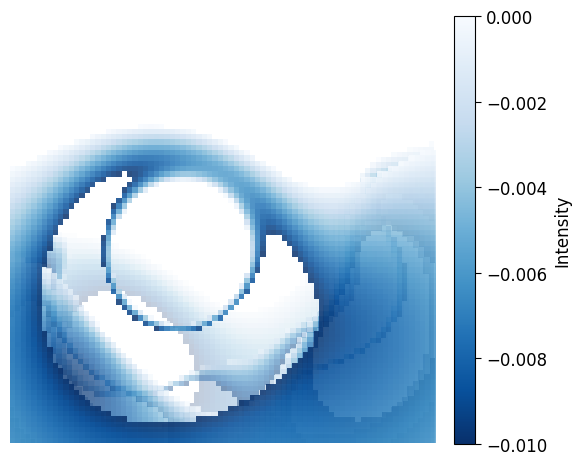

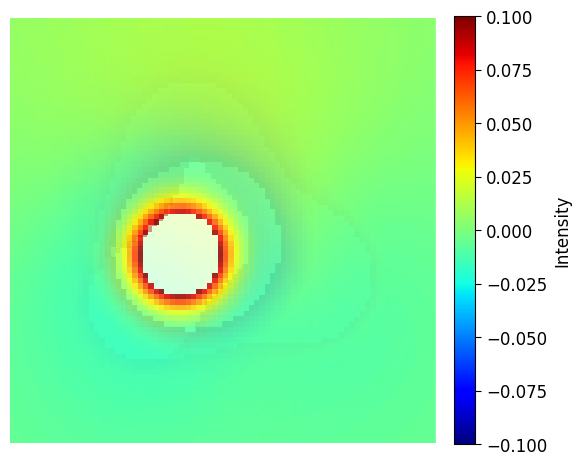

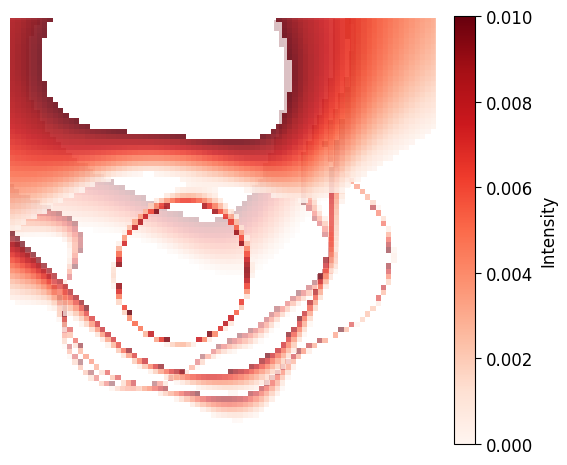

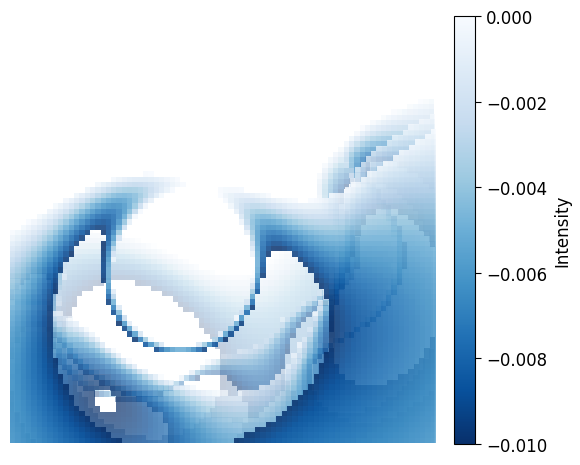

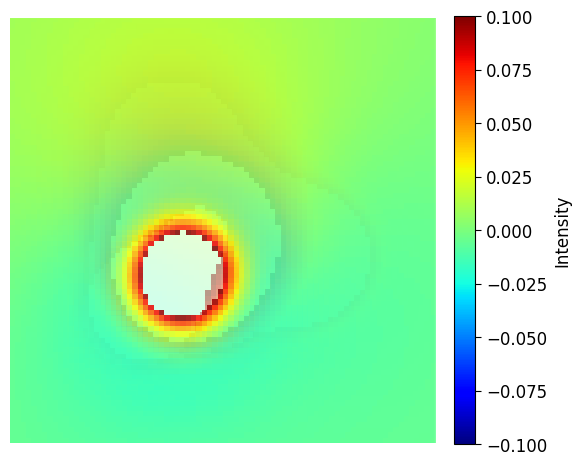

In [76]:
plot_offset_slices(cube_esp,
                   axis=0,
                    slices=list(np.arange(1,cube_esp.shape[0],cube_esp.shape[0]//5)),
                           offset=(.1, .1),
                   cmap="Reds",
                   title="",
                   # mask_fn=lambda a,b : (0.001 < a < 0.001),
                   vmin=0,
                   vmax=0.01,
                   outline=False,
                  mask_volume=(cube_dens < 0.02) & (cube_dens > 0.01) )
plot_offset_slices(cube_esp,
                   axis=0,
                    slices=list(np.arange(1,cube_esp.shape[0],cube_esp.shape[0]//5)),
                           offset=(.1, .1),
                   cmap="Blues_r",
                   title="",
                   # mask_fn=lambda a,b : (0.001 < a < 0.001),
                   vmin=-0.01,
                   vmax=0.0,
                   outline=False)
plot_offset_slices(cube_esp,
                   axis=0,
                    slices=list(np.arange(1,cube_esp.shape[0],cube_esp.shape[0]//5)),
                           offset=(.1, .1),
                   cmap="jet",
                   title="",
                   # mask_fn=lambda a,b : (0.001 < a < 0.001),
                   vmin=-0.1,
                   vmax=0.1,
                   outline=False)
cube_esp = cube_esp.T
plot_offset_slices(cube_esp,
                   axis=0,
                    slices=list(np.arange(1,cube_esp.shape[0],cube_esp.shape[0]//5)),
                           offset=(.1, .1),
                   cmap="Reds",
                   title="",
                   # mask_fn=lambda a,b : (0.001 < a < 0.001),
                   vmin=0,
                   vmax=0.01,
                   outline=False)
plot_offset_slices(cube_esp,
                   axis=0,
                    slices=list(np.arange(1,cube_esp.shape[0],cube_esp.shape[0]//5)),
                           offset=(.1, .1),
                   cmap="Blues_r",
                   title="",
                   # mask_fn=lambda a,b : (0.001 < a < 0.001),
                   vmin=-0.01,
                   vmax=0.0,
                   outline=False)
plot_offset_slices(cube_esp,
                   axis=0,
                    slices=list(np.arange(1,cube_esp.shape[0],cube_esp.shape[0]//5)),
                           offset=(.1, .1),
                   cmap="jet",
                   title="",
                   # mask_fn=lambda a,b : (0.001 < a < 0.001),
                   vmin=-0.1,
                   vmax=0.1,
                   outline=False);
